In [1]:
import ares
from millicharge.params import LCDMParams, DMBParams, ARESParams

In [2]:
lcdm_cosmo = LCDMParams()
dmb_cosmo = DMBParams()

lcdm = ARESParams(lcdm_cosmo)
dmb = ARESParams(dmb_cosmo)

sim_lcdm = ares.simulations.Global21cm(**lcdm.all_kwargs)
sim_dmb = ares.simulations.Global21cm(**dmb.all_kwargs)

Using DMBParams.  Setting include_dm to True.
# Loaded $ARES/input/inits/inits_planck_TTTEEE_lowl_lowE_best.txt.

##############################################################################################################
####                                      ARES Simulation: Overview                                       ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Uniform Backgrounds                                                                                  ####
#### ---------------------------------------------------------------------------------------------------- ####
####               sfrd      sed    radio    O/IR    Ly-a     LW     Ly-C   X-ray    RTE                  ####
#### pop #0  :    fcoll      yes                      x       x                                           ###

In [3]:
sim_dmb.run()
sim_lcdm.run()


None
None


In [18]:
dmb_newpk = ARESParams(dmb_cosmo, use_classy_pk=True)
sim_dmb_newpk = ares.simulations.Global21cm(**dmb_newpk.all_kwargs)

Using DMBParams.  Setting include_dm to True.

##############################################################################################################
####                                      ARES Simulation: Overview                                       ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Uniform Backgrounds                                                                                  ####
#### ---------------------------------------------------------------------------------------------------- ####
####               sfrd      sed    radio    O/IR    Ly-a     LW     Ly-C   X-ray    RTE                  ####
#### pop #0  :    fcoll      yes                      x       x                                           ####
#### pop #1  : link:sfrd:0   yes                                 

In [19]:
sim_dmb_newpk.run()

None


/Users/tmorton/miniconda3/envs/millicharge/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


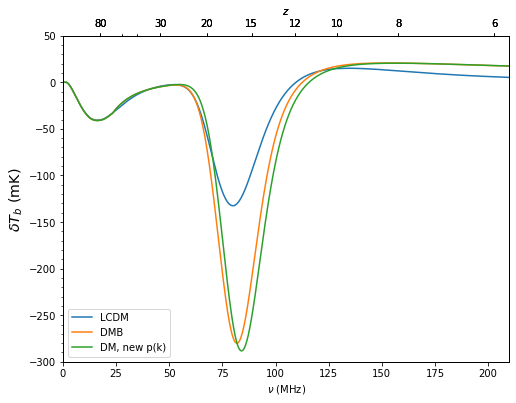

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))

sim_lcdm.GlobalSignature(ax=ax, label=r'LCDM')
sim_dmb.GlobalSignature(ax=ax, label=r'DMB')
sim_dmb_newpk.GlobalSignature(ax=ax, label='DM, new p(k)')

ax.legend()

In [10]:
import ares
import matplotlib.pyplot as plt
import numpy as np
import classy
from astropy.cosmology import Planck18_arXiv_v2 as Planck
from importlib import reload
import pickle
from millicharge import LCDM

In [11]:
class_params = LCDM.class_params()
class_params
# for k in ['N_ur', 'N_ncdm', 'm_ncdm', 'YHe', 'reionization_exponent', 'reionization_width']

{'h': 0.6766,
 'omega_b': 0.0224178568132,
 'omega_cdm': 0.11934063901639999,
 'Omega_k': 0.0,
 'N_ur': 2.046,
 'N_ncdm': 1,
 'm_ncdm': 0.06,
 'A_s': 2.097e-09,
 'n_s': 0.9652,
 'T_cmb': 2.7255,
 'tau_reio': 0.054,
 'YHe': 0.24537116583825905,
 'reionization_exponent': 1.5,
 'reionization_width': 0.5,
 'P_k_max_1/Mpc': 200,
 'output': 'dTk,mPk,tCl'}

In [12]:
m_dmb = 1  # GeV
sigma_dmb = 1e-41  # cm^2
Vrel_dmb = 35 # km/s at z ~ 1010

lcdm_params = LCDM.class_params()
dmb_params = dict(lcdm_params)
dmb_params.update({
    'omega_dmb': 0.12038, 'omega_cdm': 1e-10, 'm_dmb': m_dmb,
    'sigma_dmb': sigma_dmb, 'n_dmb': -4, 'Vrel_dmb': Vrel_dmb
})
lcdm_params['z_max_pk'] = 100.
dmb_params['z_max_pk'] = 100.

cl_lcdm = classy.Class()
cl_lcdm.set(lcdm_params)
cl_lcdm.compute()

cl_dmb = classy.Class()
cl_dmb.set(dmb_params)
cl_dmb.compute()

In [13]:
z_initial = 60
final_redshift = 10

thermo = cl_dmb.get_thermodynamics()
inputs = {
    'z': thermo['z'], 'xe': thermo['x_e'], 'Tk': thermo['Tb [K]'], 
    'Tchi': thermo['T_dmb'], 'Vchib': Vrel_dmb*1e5 * z_initial / 1010
}

In [14]:
other_params = dict(restricted_timestep=['ions', 'neutrals', 'electrons', 'temperature', 'hubble', 'idm'],
#                     epsilono_dt=0.05,
                    epsilon_dt=0.05*0.02, 
                    hmf_load=False)
#                     hmf_load=False)


cosmo_params = {'omega_m_0': (lcdm_params['omega_cdm'] + lcdm_params['omega_b']) / lcdm_params['h']**2,
                'omega_b_0': lcdm_params['omega_b'] / lcdm_params['h']**2,
                'hubble_0': lcdm_params['h'], 'primordial_index': lcdm_params['n_s'],
                'cmb_temp_0': lcdm_params['T_cmb']}

cosmology_helper_lcdm = cl_lcdm
cosmology_helper_dmb = cl_dmb

new_params_ccl = dict(cosmology_package='ccl', hmf_package='ccl', hmf_model='Tinker10', hmf_zmin=0.0)
new_params_ccl_newpk_lcdm = dict(cosmology_package='ccl', hmf_package='ccl', hmf_model='Tinker10',
                            cosmology_helper=cosmology_helper_lcdm, kmax=200, hmf_zmin=0.0)
new_params_ccl_newpk_dmb = dict(cosmology_package='ccl', hmf_package='ccl', hmf_model='Tinker10',
                            cosmology_helper=cosmology_helper_dmb, kmax=200, hmf_zmin=0.0)


initial_timestep = .001
# initial_timestep = 0.01

all_params_ccl = dict(cosmology_inits=inputs, 
                  include_dm=True, verbose=True,
                m_dmeff=m_dmb, sigma_dmeff=sigma_dmb, npow_dmb=-4,
                cosmology_name='user', initial_timestep=initial_timestep, initial_redshift=z_initial, 
                **other_params, **new_params_ccl, **cosmo_params)

all_params_ccl_newpk_lcdm = dict(cosmology_inits=inputs, 
                  include_dm=True, verbose=True,
                m_dmeff=m_dmb, sigma_dmeff=sigma_dmb, npow_dmb=-4,
                cosmology_name='user', initial_timestep=initial_timestep, initial_redshift=z_initial, 
                **other_params, **new_params_ccl_newpk_lcdm, **cosmo_params)

all_params_ccl_newpk_dmb = dict(cosmology_inits=inputs, 
                  include_dm=True, verbose=True,
                m_dmeff=m_dmb, sigma_dmeff=sigma_dmb, npow_dmb=-4,
                cosmology_name='user', initial_timestep=initial_timestep, initial_redshift=z_initial, 
                **other_params, **new_params_ccl_newpk_dmb, **cosmo_params)

all_params_ccl_nodm = dict(
                verbose=True,
                initial_timestep=initial_timestep, initial_redshift=z_initial, 
                **other_params, **new_params_ccl, **cosmo_params)

sim_ccl = ares.simulations.Global21cm(**all_params_ccl)
sim_ccl_newpk_lcdm = ares.simulations.Global21cm(**all_params_ccl_newpk_lcdm)
sim_ccl_newpk_dmb = ares.simulations.Global21cm(**all_params_ccl_newpk_dmb)
sim_ccl_nodm = ares.simulations.Global21cm(**all_params_ccl_nodm)


##############################################################################################################
####                                      ARES Simulation: Overview                                       ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Uniform Backgrounds                                                                                  ####
#### ---------------------------------------------------------------------------------------------------- ####
####               sfrd      sed    radio    O/IR    Ly-a     LW     Ly-C   X-ray    RTE                  ####
#### pop #0  :    fcoll      yes                      x       x                                           ####
#### pop #1  : link:sfrd:0   yes                                              x                           ####


In [12]:
all_params_ccl

{'cosmology_inits': {'z': array([0.00000000e+00, 4.56057442e-03, 1.78677564e-02, ...,
         9.99850000e+03, 9.99900000e+03, 9.99950000e+03]),
  'xe': array([1.16374399, 1.16374399, 1.16374399, ..., 1.16374406, 1.16374406,
         1.16374406]),
  'Tk': array([3.57223104e-01, 3.60425373e-01, 3.69882318e-01, ...,
         2.72536372e+04, 2.72550000e+04, 2.72563627e+04]),
  'Tchi': array([1.11359545e-01, 1.11994417e-01, 1.13842722e-01, ...,
         1.78819872e+02, 1.78830652e+02, 1.78841432e+02]),
  'Vchib': 207920.79207920792},
 'include_dm': True,
 'verbose': True,
 'm_dmeff': 1,
 'sigma_dmeff': 1e-41,
 'npow_dmb': -4,
 'cosmology_name': 'user',
 'initial_timestep': 0.001,
 'initial_redshift': 60,
 'restricted_timestep': ['ions',
  'neutrals',
  'electrons',
  'temperature',
  'hubble',
  'idm'],
 'epsilon_dt': 0.001,
 'hmf_load': False,
 'cosmology_package': 'ccl',
 'hmf_package': 'ccl',
 'hmf_model': 'Tinker10',
 'hmf_zmin': 0.0,
 'omega_m_0': 0.30966,
 'omega_b_0': 0.04897,
 'hub

In [17]:
for k in all_params_ccl_newpk_dmb:
    if k not in dmb_newpk.all_kwargs:
        print(k + " not in all_kwargs")
    if all_params_ccl_newpk_dmb[k] != dmb_newpk.all_kwargs[k]:
        print(f'{k}: {all_params_ccl_newpk_dmb[k]}, {dmb_newpk.all_kwargs[k]}')

<ipython-input-17-cbeea2c8c815>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if all_params_ccl_newpk_dmb[k] != dmb_newpk.all_kwargs[k]:


cosmology_inits: {'z': array([0.00000000e+00, 4.56057442e-03, 1.78677564e-02, ...,
       9.99850000e+03, 9.99900000e+03, 9.99950000e+03]), 'xe': array([1.16374399, 1.16374399, 1.16374399, ..., 1.16374406, 1.16374406,
       1.16374406]), 'Tk': array([3.57223104e-01, 3.60425373e-01, 3.69882318e-01, ...,
       2.72536372e+04, 2.72550000e+04, 2.72563627e+04]), 'Tchi': array([1.11359545e-01, 1.11994417e-01, 1.13842722e-01, ...,
       1.78819872e+02, 1.78830652e+02, 1.78841432e+02]), 'Vchib': 207920.79207920792}, {'z': array([0.00000000e+00, 8.91822125e-03, 2.22862742e-02, ...,
       9.99850000e+03, 9.99900000e+03, 9.99950000e+03]), 'xe': array([1.16374399, 1.16374399, 1.16374399, ..., 1.16374406, 1.16374406,
       1.16374406]), 'Tk': array([3.57482624e-01, 3.63774224e-01, 3.73319169e-01, ...,
       2.72536372e+04, 2.72550000e+04, 2.72563627e+04]), 'Tchi': array([1.15815449e-01, 1.17129656e-01, 1.19095079e-01, ...,
       2.14627852e+02, 2.14639921e+02, 2.14651990e+02]), 'Vchib': 1782

KeyError: 'cosmology_helper'

In [11]:
dmb.all_kwargs

{'include_dm': True,
 'verbose': True,
 'initial_redshift': 60,
 'initial_timestep': 0.001,
 'cosmology_package': 'ccl',
 'hmf_package': 'ccl',
 'hmf_model': 'Tinker10',
 'restricted_timestep': ['ions',
  'neutrals',
  'electrons',
  'temperature',
  'hubble',
  'idm'],
 'epsilon_dt': 0.001,
 'hmf_load': False,
 'hmf_zmin': 0.0,
 'omega_m_0': 0.04897000021844194,
 'omega_b_0': 0.04897,
 'hubble_0': 0.6766,
 'primordial_index': 0.9652,
 'cmb_temp_0': 2.7255,
 'cosmology_inits': {'z': array([0.00000000e+00, 8.91822125e-03, 2.22862742e-02, ...,
         9.99850000e+03, 9.99900000e+03, 9.99950000e+03]),
  'xe': array([1.16374399, 1.16374399, 1.16374399, ..., 1.16374406, 1.16374406,
         1.16374406]),
  'Tk': array([3.57482624e-01, 3.63774224e-01, 3.73319169e-01, ...,
         2.72536372e+04, 2.72550000e+04, 2.72563627e+04]),
  'Tchi': array([1.15815449e-01, 1.17129656e-01, 1.19095079e-01, ...,
         2.14627852e+02, 2.14639921e+02, 2.14651990e+02]),
  'Vchib': 178217.82178217822},
 '

In [14]:
dir(sim_ccl.cosm)

['AngleToComovingLength',
 'AngleToProperLength',
 'ComovingLengthToAngle',
 'ComovingLineElement',
 'ComovingRadialDistance',
 'CriticalDensity',
 'CriticalDensityForCollapse',
 'CriticalDensityNow',
 'DeltaZed',
 'DifferentialRedshiftElement',
 'EvolutionFunction',
 'HubbleLength',
 'HubbleParameter',
 'HubbleTime',
 'JeansMass',
 'LookbackTime',
 'LuminosityDistance',
 'MeanBaryonDensity',
 'MeanBaryonNumberDensity',
 'MeanDarkMatterDensity',
 'MeanHeliumNumberDensity',
 'MeanHydrogenNumberDensity',
 'MeanMatterDensity',
 'OmegaLambda',
 'OmegaMatter',
 'Omh2',
 'ProjectedVolume',
 'ProperLineElement',
 'ProperRadialDistance',
 'TCMB',
 'TcmbNow',
 'Tgas',
 'TimeToRedshiftConverter',
 'Tk_dec',
 'UCMB',
 'X',
 'Y',
 '_Tgas',
 '_Tgas_CosmoRec',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',

In [10]:
dict(**other_params, **new_params_ccl, **cosmo_params)

{'restricted_timestep': ['ions',
  'neutrals',
  'electrons',
  'temperature',
  'hubble',
  'idm'],
 'epsilon_dt': 0.001,
 'hmf_load': False,
 'cosmology_package': 'ccl',
 'hmf_package': 'ccl',
 'hmf_model': 'Tinker10',
 'hmf_zmin': 0.0,
 'omega_m_0': 0.30966,
 'omega_b_0': 0.04897,
 'hubble_0': 0.6766,
 'primordial_index': 0.9652,
 'cmb_temp_0': 2.7255}

In [22]:
# sim_ccl_newpk_lcdm.run()
sim_ccl_newpk_dmb.run()
sim_ccl.run()
sim_ccl_nodm.run()

None
None
None


[(-600, 100), (0, 220)]

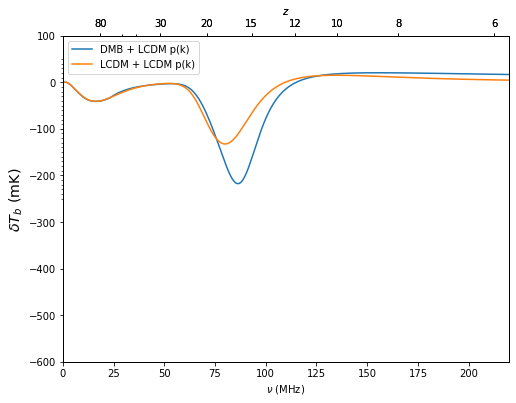

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
# sim_ccl_newpk_lcdm.GlobalSignature(ax=ax, label='LCDM, LCDM p(k)')
# sim_ccl_newpk_dmb.GlobalSignature(ax=ax, label='DMB + DMB p(k)')
sim_ccl.GlobalSignature(ax=ax, label=r'DMB + LCDM p(k)')
sim_ccl_nodm.GlobalSignature(ax=ax, label=r'LCDM + LCDM p(k)')

ax.legend()
ax.set(ylim=(-600,100), xlim=(0, 220))

In [30]:
sim_ccl.save('test_sim')

Writing test_sim.blobs.pkl...
Wrote test_sim.history.pkl
Writing test_sim.parameters.pkl...


In [37]:
sim_ccl = ares.analysis.Global21cm('test_sim')

[(-600, 100), (0, 220)]

/Users/tmorton/miniconda3/envs/millicharge/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


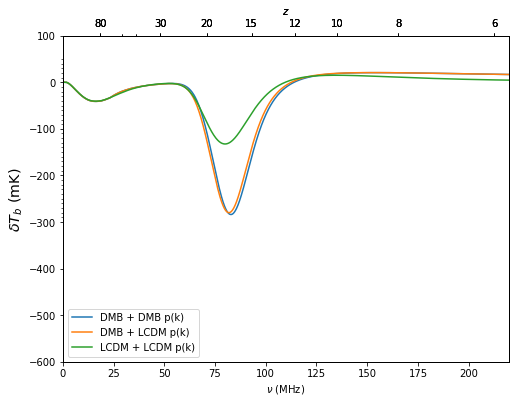

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
# sim_ccl_newpk_lcdm.GlobalSignature(ax=ax, label='LCDM, LCDM p(k)')
sim_ccl_newpk_lcdm.GlobalSignature(ax=ax, label='DMB + DMB p(k)')
sim_ccl.GlobalSignature(ax=ax, label=r'DMB + LCDM p(k)')
sim_ccl_nodm.GlobalSignature(ax=ax, label=r'LCDM + LCDM p(k)')

ax.legend()
ax.set(ylim=(-600,100), xlim=(0, 220))

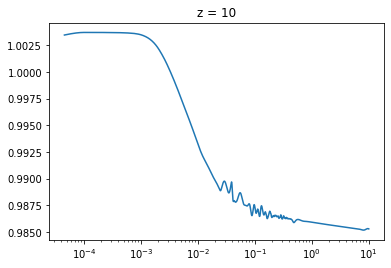

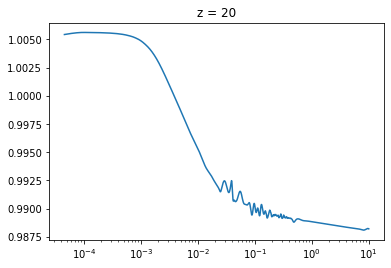

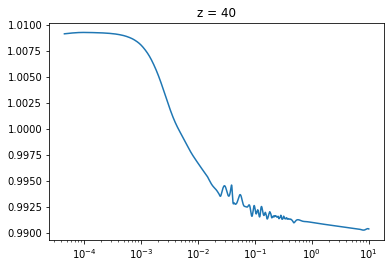

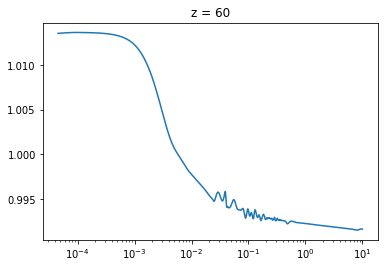

In [68]:
def plot_hmf(sim, z_index, ax=ax, **kwargs):
    
    halos = sim.pops[0].halos
    ax.loglog(halos.tab_M, halos.tab_dndm[z_index, :], **kwargs)
    ax.set_title(f'z = {halos.tab_z[z_index]}')
    ax.set_ylim(1e-30, 1)
    ax.set_xlim(1e4, 1e9)
    
def plot_pk(sim, z_index, ax=ax, **kwargs):
    halos = sim.pops[0].halos
    
    ax.loglog(halos.tab_k, halos.tab_ps_lin[z_index, :], **kwargs)
    ax.set_title(f'z = {halos.tab_z[z_index]}')
    ax.set_ylim(1e-3, 1e3)

def plot_pk_ratio(sim1, sim2, z, ax=None, kmax=200):
    halos1 = sim1.pops[0].halos
    halos2 = sim2.pops[0].halos

    mask = halos1.tab_k < kmax

    z_index_1 = np.argmin(np.abs(halos1.tab_z - z))
    z_index_2 = np.argmin(np.abs(halos2.tab_z - z))
    
    ax.semilogx(halos1.tab_k[mask], halos1.tab_ps_lin[z_index_1, mask]/halos2.tab_ps_lin[z_index_2, mask])
    ax.set_title(f'z = {z}')
    
    
# sims = [sim_ccl_newpk, sim_ccl, sim_ccl_nodm]
# labels = ['DM, new p(k)', 'DM', 'no DM']

sims = [sim_ccl_newpk_dmb, sim_ccl_newpk_lcdm]
labels = ['DM, new p(k)', 'DM']

kmax = 10
for z in [10, 20, 40, 60]:

    fig, ax = plt.subplots()

    plot_pk_ratio(sim_ccl_newpk_lcdm, sim_ccl, z, ax=ax, kmax=kmax)
#     plot_pk_ratio(sim_ccl_newpk_dmb, sim_ccl_newpk_lcdm, z, ax=ax)
    
#     for sim, label in zip(sims, labels):
# #         plot_hmf(sim, z_index, ax=ax, label=label)
#         plot_pk(sim, z_index, ax=ax, label=label)

#     ax.legend()

In [27]:
import numpy as np
import pyccl

pars = dict(omega_cdm=class_params['omega_cdm'], omega_b=class_params['omega_b'], 
            h=class_params['h'], n_s=class_params['n_s'], A_s=class_params['A_s'])

k_arr = np.logspace(-5, np.log10(200), 1000)
z_bg = np.concatenate((np.linspace(0, 10, 100), np.geomspace(10, 1500, 50)))
z_pk = np.arange(0, 60, 0.2)

def get_cosmo(pars=pars, classy_instance=None, z_bg=z_bg):
    cosmo = pyccl.Cosmology(Omega_c=pars['omega_cdm']/pars['h']**2,
        Omega_b=pars['omega_b']/pars['h']**2, h=pars['h'], n_s=pars['n_s'],
        A_s=pars['A_s'],
        transfer_function='boltzmann_camb')

    # Set background quantities in CCL using class arrays, if cosmology_helper is passed
    if classy_instance:
        cl = classy_instance

#         z_bg = np.concatenate((np.linspace(0, 10, 100), np.geomspace(10, 1500, 50)))
#         z_pk = np.arange(self.pf['hmf_zmin'], self.pf['hmf_zmax'], self.pf['hmf_dz'])
#         k_arr = np.logspace(-5, np.log10(self.pf['kmax']), 1000)

        a = 1/(1 + z_bg[::-1])
        distance = cl.z_of_r(z_bg)
        distance = np.flip(distance)

        hubble_z = np.array([cl.Hubble(z) for z in z_bg])
        H0 = hubble_z[0]
        E_of_z = hubble_z / H0
        E_of_z = np.flip(E_of_z)

        n_zk = len(z_pk)
        n_k = len(k_arr)
        class_pk_lin = cl.get_pk_array(k_arr, z_pk, n_k, n_zk, False).reshape([n_zk, n_k])[::-1, :]
        
        cosmo._set_background_from_arrays(a_array=a, chi_array=distance, hoh0_array=E_of_z)
        cosmo._set_linear_power_from_arrays(1./(1 + z_pk[::-1]), k_arr, class_pk_lin)
        
    return cosmo

cosmo = get_cosmo()
cosmo_custom = get_cosmo(classy_instance=cl_lcdm)

In [59]:
sim_ccl.pops[0].halos.tab_z

array([0.000e+00, 5.000e-02, 1.000e-01, ..., 6.000e+01, 6.005e+01,
       6.010e+01])

In [60]:
sim_ccl_newpk_lcdm.pops[0].halos.tab_z

array([ 0.9 ,  0.95,  1.  , ..., 60.  , 60.05, 60.1 ])

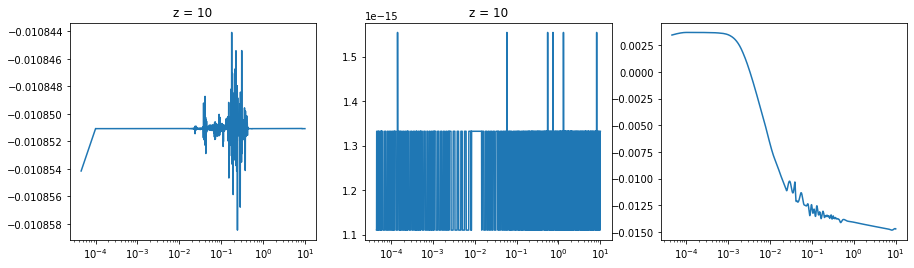

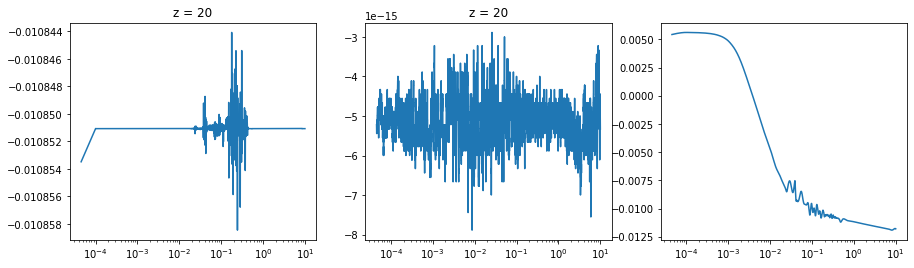

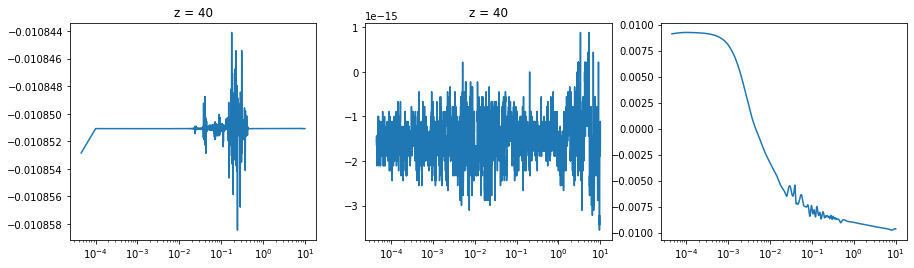

In [63]:
def compare_pk_ares_ccl(sim, cosmo, z, ax=None, kmax=10):
    halos = sim.pops[0].halos    
    
    z_index = np.argmin(np.abs(halos.tab_z - z))
    
    a = 1 / (1 + z)
    
    k_arr = halos.tab_k
    k_mask = k_arr < kmax
    
    pk_ares = halos.tab_ps_lin[z_index, k_mask]
    pk_ccl = pyccl.linear_matter_power(cosmo, k_arr[k_mask], a)
    
    ax.semilogx(k_arr[k_mask], pk_ares / pk_ccl - 1)
    ax.set_title(f'z = {z}')
    
    return k_arr[k_mask], pk_ares, pk_ccl
    
kmax = 10
for z in [10, 20, 40]:

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    k_arr_1, pk_ares, pk_ccl = compare_pk_ares_ccl(sim_ccl, cosmo, z, ax=axes[0], kmax=kmax)
    k_arr_2, pk_ares_custom, pk_ccl_custom = compare_pk_ares_ccl(sim_ccl_newpk_lcdm, cosmo_custom, z, ax=axes[1], kmax=kmax)

    axes[2].semilogx(k_arr_1, pk_ares_custom / pk_ares - 1)

#     ax.semilogx(k_arr, pk_ares_custom / pk_ccl_custom)    


NameError: name 'sim_hmf_nodm' is not defined

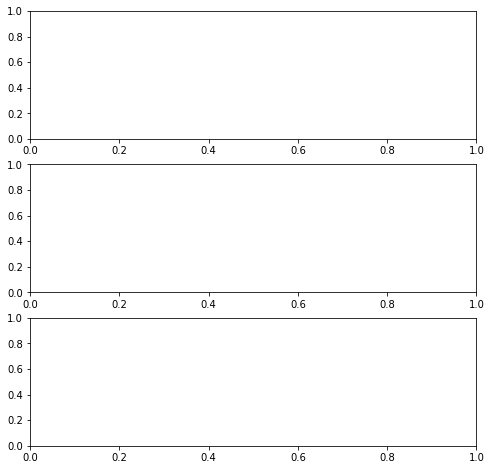

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
for sim in [sim_hmf_nodm, sim_ccl_nodm]:
    axes[0].plot(sim.history['z'], sim.history['Ja'])
    axes[0].set_xlim((5, 30))
    
    z = sim.pops[0].halos.tab_z
    axes[1].plot(z, sim.pops[0].SFRD(z))
    
#     axes[2].plot(z, sim.pops[0]._fcoll)

In [32]:
sim.pops[0]._fcoll

None
None


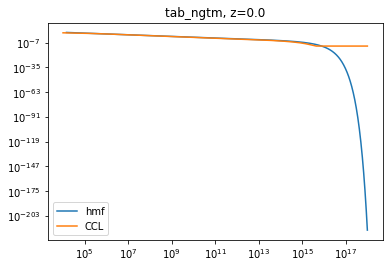

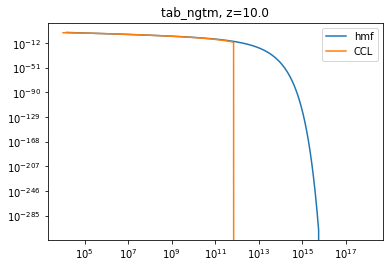

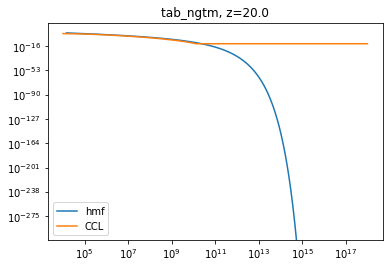

In [11]:
from scipy.interpolate import interp1d

halos_hmf = sim_hmf.pops[0].halos
halos_ccl = sim_ccl.pops[0].halos

Mmin = 1e4
Mmax = 1e18

hmf_mask = (Mmin < halos_hmf.tab_M) & (halos_hmf.tab_M < Mmax)
ccl_mask = (Mmin < halos_ccl.tab_M) & (halos_ccl.tab_M < Mmax)

ccl_factor = 1  # halos_ccl.tab_M ** 2

z_indices = [0, 200, 400]

for z_index in z_indices:

    z = halos_hmf.tab_z[z_index]
    a = 1/(1 + z)

#     ccl_factor = halos_ccl.tab_M[ccl_mask]**(-2)
    
    fig, ax = plt.subplots()
    
    hmf_fn = interp1d(halos_hmf.tab_M, halos_hmf.tab_dndm[z_index, :], fill_value='extrapolate')
    ccl_fn = interp1d(halos_ccl.tab_M, halos_ccl.tab_dndm[z_index, :], fill_value='extrapolate')
    
    m_grid = np.logspace(np.log10(Mmin), np.log10(Mmax), 500)
    m_grid = halos_ccl.tab_M
    
#     ax.loglog(halos_hmf.tab_M[hmf_mask], halos_hmf.tab_dndm[z_index, hmf_mask], label='hmf')
#     ax.loglog(halos_ccl.tab_M[ccl_mask], halos_ccl.tab_dndm[z_index, ccl_mask] * ccl_factor, ls='--', label='CCL')
#     ax.loglog(m_grid, hmf_fn(m_grid), label='hmf')
#     ax.loglog(m_grid, ccl_fn(m_grid), ls='--', label='ccl')
#     ratio = ccl_fn(m_grid) / hmf_fn(m_grid)
#     ax.loglog(m_grid, ratio, label='ccl/hmf')
#     ax.set_title(f'tab_dndm, z={z}')

    ax.loglog(halos_hmf.tab_M[hmf_mask], halos_hmf.tab_ngtm[z_index, hmf_mask], label='hmf')
    ax.loglog(halos_ccl.tab_M[ccl_mask], halos_ccl.tab_ngtm[z_index, ccl_mask], label='CCL')
    ax.set_title(f'tab_ngtm, z={z}')

#     ax.set_ylim((1e-15, 1e2))
#     ax.set_xlim((1e5, 1e15))
    ax.legend()

In [123]:
hmf_fn(halos_ccl.tab_M)

array([1.69342532e-07, 1.64382098e-07, 1.59306120e-07, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [124]:
np.savetxt('')

Signature:
np.savetxt(
    fname,
    X,
    fmt='%.18e',
    delimiter=' ',
    newline='\n',
    header='',
    footer='',
    comments='# ',
    encoding=None,
)
Docstring:
Save an array to a text file.

Parameters
----------
fname : filename or file handle
    If the filename ends in ``.gz``, the file is automatically saved in
    compressed gzip format.  `loadtxt` understands gzipped files
    transparently.
X : 1D or 2D array_like
    Data to be saved to a text file.
fmt : str or sequence of strs, optional
    A single format (%10.5f), a sequence of formats, or a
    multi-format string, e.g. 'Iteration %d -- %10.5f', in which
    case `delimiter` is ignored. For complex `X`, the legal options
    for `fmt` are:

    * a single specifier, `fmt='%.4e'`, resulting in numbers formatted
      like `' (%s+%sj)' % (fmt, fmt)`
    * a full string specifying every real and imaginary part, e.g.
      `' %.4e %+.4ej %.4e %+.4ej %.4e %+.4ej'` for 3 columns
    * a list of specifiers, one pe

In [44]:
len(halos_hmf.tab_z)

1203

(1203, 1400)

In [24]:
halos_hmf.SaveHMF(fn='test_hmf_hmf.hdf5')

# Wrote test_hmf_hmf.hdf5.


In [26]:
halos_hmf.tab_sigma

array([12.03741553, 12.01669783, 11.99601245, ...,  0.04295449,
        0.04247322,  0.0419965 ])

In [25]:
halos_ccl.tab_sigma

hello tab_sigma


OSError: Unable to open file (unable to open file: name = '/Users/tmorton/repositories/ares/input/hmf/hps_Tinker10_logM_1400_4-18_z_49_6-30_lnR_-10.0-10.0_dlnR_0.001_lnk_-10.0-10.0_dlnk_0.001.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [23]:
halos_ccl.SaveHMF(fn='test_ccl_hmf.hdf5', clobber=True)

hello tab_sigma


OSError: Unable to open file (unable to open file: name = '/Users/tmorton/repositories/ares/input/hmf/hps_Tinker10_logM_1400_4-18_z_49_6-30_lnR_-10.0-10.0_dlnR_0.001_lnk_-10.0-10.0_dlnk_0.001.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [18]:
halos_hmf.tab_ngtm.shape

(1203, 1400)

In [19]:
halos_ccl.tab_ngtm.shape

(1203, 1401)

In [14]:
hmf_mask

[array([ True,  True,  True, ..., False, False, False])]

In [17]:
# sim_ccl_nodm.run()

# sim_hmf_nodm.run()

[(-300, 100), (0, 220)]

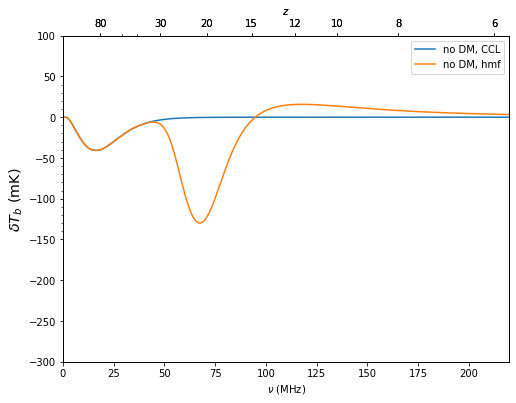

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
sim_ccl_nodm.GlobalSignature(ax=ax, label=r'no DM, CCL')
sim_hmf_nodm.GlobalSignature(ax=ax, label=r'no DM, hmf')
# sim1.GlobalSignature(ax=ax, label=r'$\sigma=10^{-41}, V_{\chi^b}=2.5 \mathrm{km/s}$')
# sim_noVrel.GlobalSignature(ax=ax, label=r'Vchib =0')
# sim_nodm.GlobalSignature(ax=ax, label=r'no_dm')

ax.legend()
ax.set(ylim=(-300,100), xlim=(0, 220))

In [7]:
sim_hmf.pops[0].halos.tab_dndm

None
> /Users/tmorton/repositories/ares/ares/physics/HaloMassFunction.py(720)TabulateHMF()
-> self.tab_dndm = np.zeros([self.tab_z.size, self.tab_M.size])


(Pdb)  self.tab_M


array([1.47623265e+04, 1.51061853e+04, 1.54580536e+04, ...,
       1.37770047e+18, 1.40979124e+18, 1.44262950e+18])


(Pdb)  len(self.tab_M)


1400


(Pdb)  self._MF


(Pdb)  self


(Pdb)  q


BdbQuit: 

In [9]:
sim_ccl.pops[0].halos.tab_dndm

None
> /Users/tmorton/repositories/ares/ares/physics/HaloMassFunction.py(715)TabulateHMF()
-> self.tab_M = tab_M #/ self.cosm.h70


(Pdb)  len(tab_M)


1401


(Pdb)  log10M


array([ 4.  ,  4.01,  4.02, ..., 17.98, 17.99, 18.  ])


(Pdb)  q


BdbQuit: 

In [ ]:
import numpy as np

np.allclose(sim_hmf.pops[0].halos.tab_dndm, sim_ccl.pops[0].halos.tab_dndm)

In [26]:
sim_ccl.pops[0].halos.tab_dndm.shape

(1203, 1401)

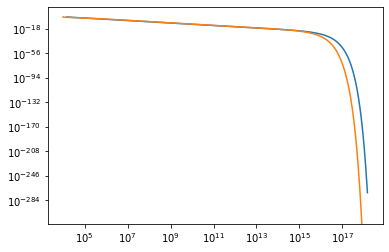

In [29]:
plt.loglog(sim_hmf.pops[0].halos.tab_M, sim_hmf.pops[0].halos.tab_dndm[0, :])
plt.loglog(sim_ccl.pops[0].halos.tab_M, sim_ccl.pops[0].halos.tab_dndm[0, :])


In [24]:
np.allclose(sim_hmf.pops[0].halos.tab_z, sim_ccl.pops[0].halos.tab_z)

True

In [25]:
np.allclose(sim_hmf.pops[0].halos.tab_M, sim_ccl.pops[0].halos.tab_M)

ValueError: operands could not be broadcast together with shapes (1400,) (1401,) 

In [15]:
from astropy import units as u

In [16]:
cosm = sim.cosm

In [17]:
cosm.rho_crit_0

8.620826080363533e-30

In [18]:
from ares.physics import Cosmology

cosm = Cosmology()
cosm_ccl = Cosmology(cosmology_package="ccl")


In [19]:
cosm.rho_crit_0

8.514706440930017e-30

In [20]:
cosm_ccl.rho_crit_0

8.514706440930017e-30

In [22]:
cosm.h70

0.6732178000000001

In [23]:
cosm_ccl.h70

0.6732178000000001

In [32]:
cosm.CriticalDensity(10)

3.58477324647514e-27

In [33]:
cosm_ccl.CriticalDensity(10)

3.58477324647514e-27

In [26]:
cosm.rho_b_z0, cosm_ccl.rho_b_z0

(4.204046797532808e-31, 6182542911.238998)

In [29]:
h = cosm_ccl.h70
h = 1
(cosm_ccl.rho_b_z0 * (u.Msun / h) / (u.Mpc / h)**3).cgs

<Quantity 4.18428651e-31 g / cm3>

In [35]:
import pyccl

pyccl.rho_x?

Signature: pyccl.rho_x(cosmo, a, species, is_comoving=False)
Docstring:
Physical or comoving density as a function of scale factor.

Args:
    cosmo (:class:`~pyccl.core.Cosmology`): Cosmological parameters.
    a (float or array_like): Scale factor(s), normalized to 1 today.
    species (string): species type. Should be one of

        - 'matter': cold dark matter, massive neutrinos, and baryons
        - 'dark_energy': cosmological constant or otherwise
        - 'radiation': relativistic species besides massless neutrinos
        - 'curvature': curvature density
        - 'neutrinos_rel': relativistic neutrinos
        - 'neutrinos_massive': massive neutrinos

    is_comoving (bool): either physical (False, default) or comoving (True)

Returns:
    rho_x (float or array_like): Physical density of a given species
    at a scale factor.
File:      ~/repositories/CCL/pyccl/background.py
Type:      function


In [6]:
%tb

SystemExit: 1

In [6]:
pop = ares.populations.HaloPopulation(**all_params)

In [9]:
pop.halos.TabulateHMF(save_MAR=False)

In [10]:
pop.halos.tab_MAR

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.21725902e-01, 1.21725902e-01, 6.78311598e-02, ...,
        1.12130442e+13, 1.12130442e+13, 1.12130442e+13],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [7]:
pop.halos.tab_z

None


array([ 0.9 ,  0.95,  1.  , ..., 60.  , 60.05, 60.1 ])

In [8]:
pop.cosm.HubbleParameter(pop.halos.tab_z)

array([3.67989559e-18, 3.79066767e-18, 3.90387444e-18, ...,
       5.81299773e-16, 5.82014626e-16, 5.82729771e-16])

In [29]:
pop.cosm.HubbleParameter(50)

4.443878612294519e-16

In [15]:
pop.halos.tab_k_lin

array([4.53999298e-05, 4.54453524e-05, 4.54908205e-05, ...,
       2.19824569e+04, 2.20044503e+04, 2.20264658e+04])

In [17]:
pop.halos.tab_ps_lin

array([[9.23424089e+02, 9.24316182e+02, 9.25209137e+02, ...,
        3.81204355e-10, 3.80198095e-10, 3.79194492e-10],
       [8.76304581e+02, 8.77151158e+02, 8.77998552e+02, ...,
        3.61768858e-10, 3.60813902e-10, 3.59861466e-10],
       [8.31357094e+02, 8.32160253e+02, 8.32964188e+02, ...,
        3.43235869e-10, 3.42329834e-10, 3.41426191e-10],
       ...,
       [3.76677751e-01, 3.77041952e-01, 3.77406506e-01, ...,
        1.70782266e-13, 1.70331504e-13, 1.69881931e-13],
       [3.76044408e-01, 3.76407997e-01, 3.76771938e-01, ...,
        1.70507818e-13, 1.70057780e-13, 1.69608930e-13],
       [3.75412701e-01, 3.75775680e-01, 3.76139009e-01, ...,
        1.70234066e-13, 1.69784750e-13, 1.69336621e-13]])

In [18]:
pop.halos.tab_ngtm

array([[ 4.69419706e+04,  4.52093893e+04,  4.42248904e+04, ...,
         3.63797881e-11,  3.63797881e-11,  3.63797881e-11],
       [ 4.75968828e+04,  4.58394141e+04,  4.48407847e+04, ...,
         2.91038305e-11,  2.91038305e-11,  2.91038305e-11],
       [ 4.82118838e+04,  4.64309433e+04,  4.54189887e+04, ...,
        -2.18278728e-11, -2.18278728e-11, -2.18278728e-11],
       ...,
       [ 3.21130076e-06,  2.72502408e-06,  2.47192229e-06, ...,
         2.96461532e-21,  2.96461532e-21,  2.96461532e-21],
       [ 3.08201461e-06,  2.61479338e-06,  2.37164460e-06, ...,
         1.69406589e-21,  1.69406589e-21,  1.69406589e-21],
       [ 2.95784019e-06,  2.50894214e-06,  2.27536252e-06, ...,
        -4.23516474e-22, -4.23516474e-22, -4.23516474e-22]])

In [ ]:
import pyccl

cosmo = pyccl.Cosmology(Omega_c=0.26030000000000003, Omega_b=0.0486, h=0.6774, n_s=0.9667, sigma8=0.8159, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_camb', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

In [ ]:
M = 

In [7]:
import numpy as np

In [12]:
np.arange(1, 12.01, 0.01)

array([ 1.  ,  1.01,  1.02, ..., 11.98, 11.99, 12.  ])

In [8]:
np.arange(1, 18.01, 0.01)

array([ 1.  ,  1.01,  1.02, ..., 17.99, 18.  , 18.01])

In [11]:
np.arange(1, 25.01, 0.01)

array([ 1.  ,  1.01,  1.02, ..., 24.98, 24.99, 25.  ])

In [13]:
np.arange(1, 20.01, 0.01)

array([ 1.  ,  1.01,  1.02, ..., 19.99, 20.  , 20.01])

In [30]:
import pyccl

transfer_function = 'boltzmann_camb'
cosmo = pyccl.Cosmology(Omega_c=0.2649991512932126, Omega_b=0.04937394878728927, h=0.6732178000000001, n_s=0.9667, sigma8=0.8119545, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function=transfer_function, matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

In [88]:
params = {'h': 0.6766,
 'omega_b': 0.0224178568132,
 'omega_cdm': 0.11934063901639999,
 'Omega_k': 0.0,
 'N_ur': 2.046,
 'N_ncdm': 1,
 'm_ncdm': 0.06,
 'A_s': 2.097e-09,
 'n_s': 0.9652,
 'T_cmb': 2.7255,
 'tau_reio': 0.054,
 'YHe': 0.24537116583825905,
 'reionization_exponent': 1.5,
 'reionization_width': 0.5,
 'P_k_max_1/Mpc': 200,
 'output': 'dTk,mPk,tCl'}

cosmo = pyccl.Cosmology(Omega_c=params['omega_cdm'], 
                        Omega_b=params['omega_b'],
                        h=params['h'],
                        n_s=params['n_s'], A_s=params['A_s'])

In [87]:
import classy

kmax = 200
z_pk = 60
class_params = {"P_k_max_1/Mpc": kmax, "output": "dTk,mPk,tCl", 'z_pk': z_pk}
params.update(class_params)
cl = classy.Class()
cl.set(params)
cl.compute()


In [89]:
import numpy as np

z_bg = np.concatenate((np.linspace(0, 10, 100), np.geomspace(10, 1500, 50)))  # mean recomb. history
z_pk = np.linspace(0., 20., 64)  # ARES HMF tabulates over specified redshift, mass
k_arr = np.logspace(-5, np.log10(kmax), 1000)

def set_cosmo_arrays(cosmo, cl, z_bg=z_bg, kmax=kmax, k_arr=k_arr, z_pk=z_pk):
    """Sets background and power arrays in cosmo using Class instance
    """
    a = 1/(1 + z_bg[::-1])
    distance = cl.z_of_r(z_bg)
    distance = np.flip(distance)

    hubble_z = np.array([cl.Hubble(z) for z in z_bg])
    H0 = hubble_z[0]
    E_of_z = hubble_z / H0
    E_of_z = np.flip(E_of_z)

    class_pk_lin = cl.get_pk_array(k_arr, z_pk, 1000, 64, False).reshape([64, 1000])[::-1, :]

    cosmo._set_background_from_arrays(a_array=a, chi_array=distance, hoh0_array=E_of_z)
    cosmo._set_linear_power_from_arrays(1./(1 + z_pk[::-1]), k_arr, class_pk_lin)    

In [90]:
set_cosmo_arrays(cosmo, cl)

In [91]:
mdef = pyccl.halos.MassDef(500, 'critical')

hmf = pyccl.halos.MassFuncTinker10(cosmo, mass_def=mdef)

In [92]:
hmf._get_Delta_m(cosmo, 1.0)

3527.125461327004

In [77]:
Mgrid = np.logspace(6, 12, 100)

def z_to_a(z):
    return 1 / (1 + z)

hmf.get_mass_function(cosmo, Mgrid, 1.0)

ValueError: A value in x_new is above the interpolation range.